This notebook is based on the example shown on the tensorflow website, applied to a custom sinusoidal envelop function.
https://www.tensorflow.org/tutorials/structured_data/time_series
In particular, we apply the LSTM model to a time series with noise, and monitor the deltas between the predicted future timesteps and the realized future timesteps.

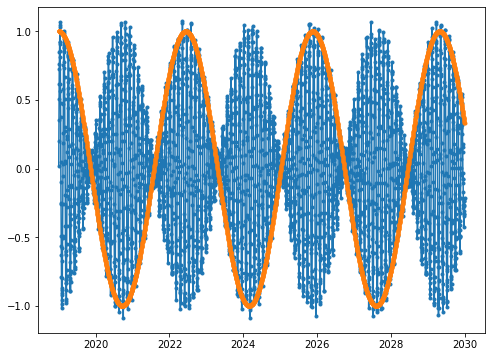

In [11]:
import tensorflow as tf
import pydot
from tensorflow.keras.utils import plot_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime as dt
import math
import random
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


# Sinusoidal envelop function
def generate_data(start_date,end_date,env_freq,inner_freq,noise_factor):
    
    nmax=(end_date-start_date).days

    list_dates=[(start_date + dt.timedelta(days=i)).date() for i in range(0,nmax)]
    values_1 = np.array([math.cos(i*env_freq)*math.sin(i*inner_freq)+noise_factor*random.uniform(-1,1) for i in range(len(list_dates))])
    values_2 = np.array([math.cos(i*env_freq) for i in range(len(list_dates))])
    
    values = np.array([values_1,values_2]).T
    
    return([list_dates,np.array(values)])


start_date=dt.datetime(2019,1,1)
end_date=dt.datetime(2030,1,1)

dat = generate_data(start_date,end_date,0.005,0.15,0.1)
plt.plot(dat[0],dat[1],marker='.')
None

In [9]:
# Preprocess data for tf library
def package_data(dat,train_size,series_size):
    val = dat[1]
    n = len(val)
    assert(n>train_size)
    assert(train_size>series_size)

    
    m_train = train_size-series_size
    x_train = [0]*m_train
    y_train = [0]*m_train

    m_validate = n-train_size-series_size
    x_validate = [0]*m_validate
    y_validate = [0]*m_validate
    
    for i in range(0,m_train):
        x_train[i] = [o for o in val[i:i+series_size]]
        y_train[i] = val[i+series_size][0]
    for i in range(0,m_validate):
        x_validate[i] = [o for o in val[i+train_size:i+train_size+series_size]]
        y_validate[i] = val[i+train_size+series_size][0]
    
    return(np.array(x_train),np.array(y_train),np.array(x_validate),np.array(y_validate))



In [10]:
# Train model

BATCH_SIZE = 256 
BUFFER_SIZE = 10000
N_DAT = len(dat[1])
TRAIN_SIZE = round(N_DAT*0.8)
SERIES_SIZE = 20

mu = dat[1][0:TRAIN_SIZE].mean(axis=0)
sigma = dat[1][0:TRAIN_SIZE].std(axis=0)
dat_std = [dat[0], (dat[1]-mu) / sigma]

x_train,y_train,x_val,y_val = package_data(dat_std,TRAIN_SIZE,SERIES_SIZE)

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(1) #predicts 1 output number
])

simple_lstm_model.compile(optimizer='adam', loss='mse')

EVALUATION_INTERVAL = 100
EPOCHS = 10

history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)



Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 3s 30ms/step - loss: 0.6538 - val_loss: 0.3152
Epoch 2/10
100/100 [==============================] - 1s 13ms/step - loss: 0.2565 - val_loss: 0.0959
Epoch 3/10
100/100 [==============================] - 1s 13ms/step - loss: 0.0842 - val_loss: 0.0429
Epoch 4/10
100/100 [==============================] - 2s 16ms/step - loss: 0.0422 - val_loss: 0.0308
Epoch 5/10
100/100 [==============================] - 1s 13ms/step - loss: 0.0308 - val_loss: 0.0259
Epoch 6/10
100/100 [==============================] - 1s 14ms/step - loss: 0.0253 - val_loss: 0.0231
Epoch 7/10
100/100 [==============================] - 2s 16ms/step - loss: 0.0223 - val_loss: 0.0213
Epoch 8/10
100/100 [==============================] - 1s 13ms/step - loss: 0.0206 - val_loss: 0.0200
Epoch 9/10
100/100 [==============================] - 1s 13ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 10/10
100/100 [===========================

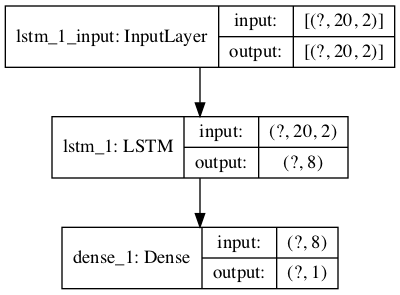

In [12]:
plot_model(simple_lstm_model, show_shapes=True, show_layer_names=True)

In [13]:
simple_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 352       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


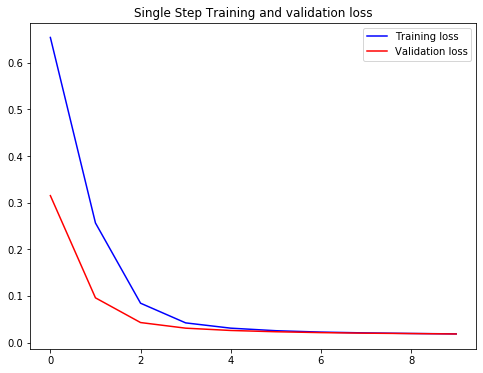

In [14]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(history,'Single Step Training and validation loss')

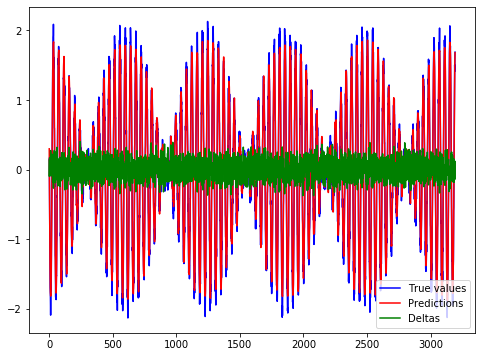

In [15]:
predictions_x = tf.constant(x_train)
train_predict = simple_lstm_model.predict(predictions_x).flatten()
def plot_train_history(y_predict,y_true, title):
    plt.figure()
    plt.plot(y_true.T,'b',label='True values')
    plt.plot(y_predict,'r',label='Predictions')
    plt.plot((y_predict-y_true.T),'g',label='Deltas')
    plt.legend(loc='best')
    plt.show()
    
plot_train_history(train_predict,y_train,'f')

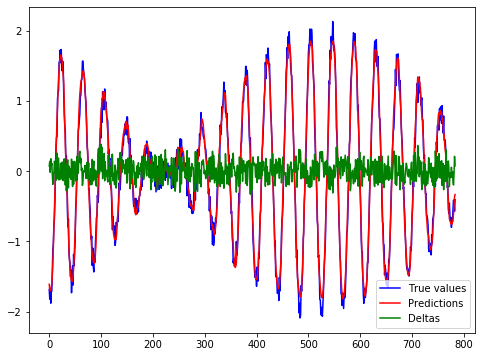

In [17]:
predictions_x = tf.constant(x_val)
val_predict = simple_lstm_model.predict(predictions_x).flatten()
plot_train_history(val_predict,y_val,'f')

# The deltas are on the order of the random noise.